# Característica Fresnel

A continuación se desarrolla el análisis de la primera zona de Fresnel que permite crear una característica adicional dada la entrada de las siguientes características:

* Coordenadas de punto.
* Altura de punto.
* Coordenadas de vecino.
* Altura de vecino.
* Frecuencia de enlace RF.

El desarrollo completo está comprendido en los apéndices y la explicación general en el capítulo 3 del trabajo escrito.

## Fresnel en 2D

Las zonas de Fresnel en un plano de dos dimensiones tienen la forma de una elipse. En los focos se encuentran el transmisor (**T**) y el receptor (**R**).

La distancia entre los dos puntos se puede obtener con la fórmula de Haversine.

In [1]:
#Importando paquetes útiles
import sys
import math
import numpy as np
sys.path.append('../')
import matplotlib as mpl
from scipy import constants
from matplotlib.patches import Ellipse
#from matplotlib import pyplot as plt
from Python.FeatureEngeeniering.Fresnel import fresnelFeature as ff
from Python.Style.styles import  *

In [2]:
#Los datos se almacenarán en un diccionario.
#Las coordenadas siguientes son un ejemplo y no corresponden a un enlace real.
linkData = {
    'lat1' : 14.2776,
    'lon1' : -90.7902,
    'h1' : 5,
    'lat2' : 14.3149,
    'lon2' : -90.777,
    'h2' : 15,
    'freq' : 915000000,
    }

In [3]:
#Utilizando diseño base 1
plt.style.use('../Python/Style/style1.mplstyle')

In [4]:
#Colores base
#Diseño base
mClr = designC['cs']
sClr1 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

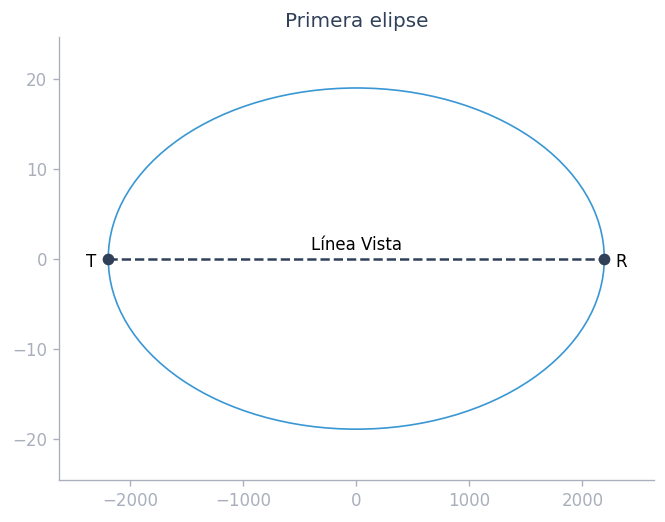

In [5]:
#Actualizando parámetros configurados
plt.rcParams.update(plt.rcParams)
#Primera elipse:
#La función cord2vec aplica Haversine dado un par de coordenadas devuelve la distancia.
d0 = ff.cord2dis(linkData)
#Para gráficar la elipse se calculan los siguientes valores numéricos.
#Relaciones de elipse.
f = linkData['freq']
c = d0/2
b = 1/2 * math.sqrt(constants.speed_of_light*d0/f) #Semieje menor según análisis Fresnel.
a = math.sqrt(c**2 + b**2)
#La librería matplotlib permite la gráfica de una elipse en un plano.
cplot = plt.figure()
elp0 = Ellipse(xy =(0,0), fill = False, width = 2*a, height = 2*b, color = mClr)#  mClr
ax = cplot.gca()
plt.xlim(-a*1.2,a*1.2)
plt.ylim(-b*1.3,b*1.3)
plt.title("Primera elipse")
ax.add_patch(elp0)
ax.plot([-c,c],[0,0], linestyle="--", marker = "o", color = sClr1)
ax.annotate("T",(-c*1.07,-0.05*b), ha = 'center')
ax.annotate("R",(c*1.07,-0.05*b), ha = 'center')
ax.annotate("Línea Vista",(0,0.05*b), ha='center')
plt.show()

En el caso específico de la comunicación inalámbrica tratada, es indistinguible cuál de los equipos se comporta como transmisor y receptor. Más aún, en la realidad los equipos desplegados en campo no están encontrados entre sí por una línea recta (línea vista), sino que se encuentran en una geografía cambiante.

Esa es la razón que motiva la determinación de la "Característica Fresnel". Para conseguir mapear la zona de fresnel de manera que se ajuste lo más posible la situación real en el terreno se utiliza "Elevation Api", un servicio de Google que dado un par de coordenadas devuelve la altimetría aproximada.

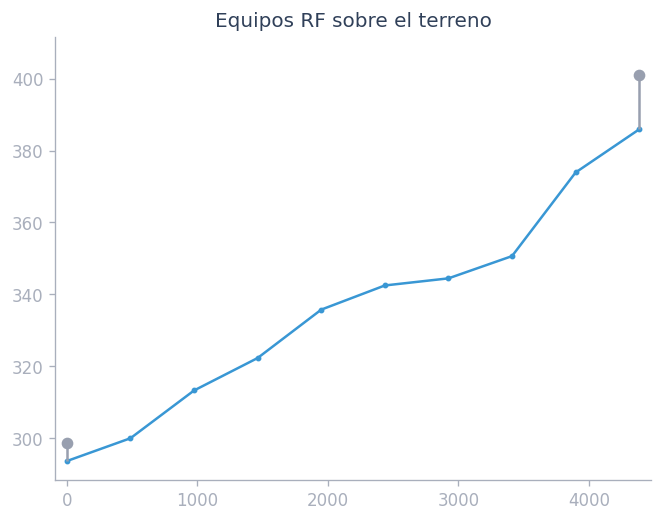

In [6]:
#pathCreator devuelve n puntos en la línea recta que conecta los dos puntos de interés.
n = 10
path = ff.pathCreator(linkData,n)
#getElevation consulta api ydevuelve altitud de puntos consultados.
eVec, rVec = ff.getElevation(path)
#getDist devuelve la distancia desde el punto más a la izquierda para todo un path.
distVec = ff.getDist(path)
#La distancia entre los puntos ahora es una hipotenusa.
h1 = linkData['h1'] + eVec[0]
h2 = linkData['h2'] + eVec[-1]
#Ajustando tamaño de gráfico
Dalt = distVec[-1]#Distancia más lejana
deltaH = h1 - h2
De = math.sqrt(Dalt**2 + deltaH**2)#Distancia entre transmisor y receptor
hmx = np.max([h1,h2,np.max(eVec)])
hmin = np.min([h1,h2,np.min(eVec)])
hn = hmx-hmin
#Gráfica de puntos con geografía incluída.
cplot = plt.figure()
ax = cplot.gca()
plt.ylim(hmin - hn*0.05,hmx + hn *0.1)
plt.xlim(-De*0.02,Dalt*1.02)
ax.plot(distVec,eVec, marker = ".", markersize = 5,color = mClr)
#Torres
torresD = [distVec[i] for i in [0,-1]]
torresMin = [eVec[i] for i in [0,-1]]
torresMax = [h1,h2]
plt.vlines(torresD,torresMin,torresMax, color = sClr2)
plt.scatter(torresD,torresMax, color = sClr2)
plt.title("Equipos RF sobre el terreno")
plt.show()

La elipse que representa la primera zona de Fresnel ahora tiene un tamaño distinto y se encuentra rotada según la diferencia de alturas entre ambos puntos. Se realizan las transformaciones correspondientes para mapearla sobre el mismo plano que la geografía.

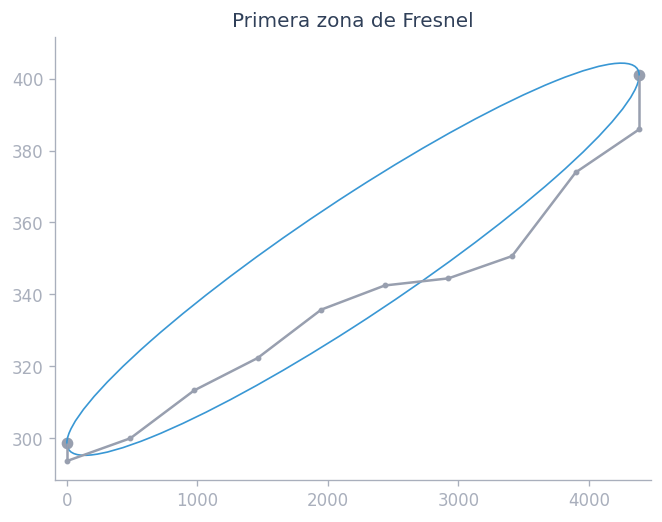

In [7]:
#Variables relacionados con la rotación de la elipse.
De = math.sqrt(Dalt**2 + deltaH**2)
beta = math.atan(-deltaH/Dalt)
b0 = h1
De = math.sqrt(Dalt**2 + deltaH**2)
beta = math.atan(-deltaH/Dalt)
b = 1/2 * math.sqrt(constants.speed_of_light*De/f)
m = -deltaH/Dalt
Xc = Dalt/2
#Función de la recta que corresponde a la línea vista
lEq = lambda xi: m*(xi) + b0
veclEq = np.vectorize(lEq)
Yc = lEq(Xc)
Cf = De/2
a = math.sqrt(Cf**2 + b**2)
yiVec = veclEq(distVec)
#Torres
cplot = plt.figure()
ax = cplot.gca()
plt.ylim(hmin - hn*0.05,hmx + hn *0.1)
plt.xlim(-De*0.02,Dalt*1.02)
ax.plot(distVec,eVec, marker = ".", markersize = 5, color = sClr2)
fresEllips = Ellipse(xy = (Xc,Yc), fill = False, width = 2*a, height = 2*b, angle = math.degrees(beta), color = mClr)
plt.vlines(torresD,torresMin,torresMax, color = sClr2)
plt.scatter(torresD,torresMax, color = sClr2)
ax.add_patch(fresEllips)
plt.title("Primera zona de Fresnel")
plt.show()

La característica buscada es la fracción de la zona de Fresnel que se ve obstruída por la geografía circundante a los equipos de la red de comunicaciones.

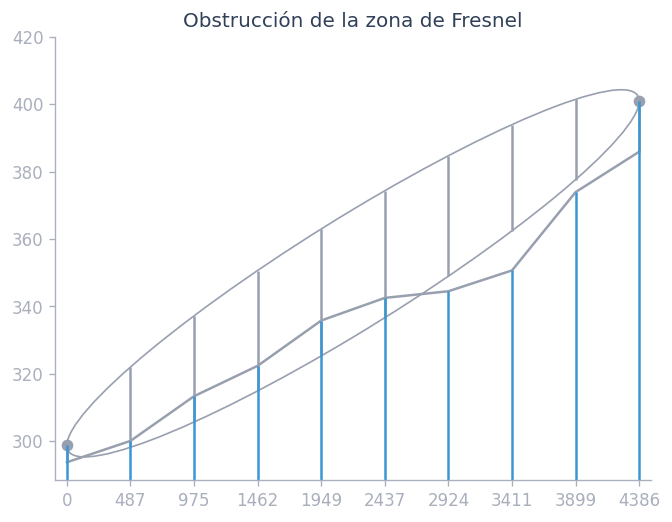

In [8]:
#Modificando estilo
plt.rcParams.update({'axes.spines.right': False,'axes.spines.top': False})
#Calculo de puntos críticos
diEq = np.vectorize(lambda xi: math.sqrt(xi**2 + (b0-lEq(xi))**2))
hdiEq = np.vectorize(lambda di: math.sqrt((di*(De-di)*constants.speed_of_light)/(De*f)))
tdiVec = diEq(distVec)
hdiVec = hdiEq(tdiVec)
yhdiVec = hdiVec * math.cos(beta)
restVec = -tdiVec + De
downP = yiVec - yhdiVec
upP = yiVec + yhdiVec
#Torres
cplot = plt.figure()
ax = cplot.gca()
#plt.ylim(hmin - hn*0.05,hmx + hn *0.1)
plt.xlim(-De*0.02,Dalt*1.02)
ax.plot(distVec,eVec, markersize = 5, color = sClr2)
fresEllips = Ellipse(xy = (Xc,Yc), fill = False, width = 2*a, height = 2*b, angle = math.degrees(beta), color = sClr2)
plt.vlines(distVec,downP,upP, colors = sClr2)
plt.vlines(torresD,torresMin,torresMax, color = sClr2)
plt.scatter(torresD,torresMax, color = sClr2)
ax.add_patch(fresEllips)
yMins = [hmin - hn*0.05]*n
cpVec = eVec
cpVec[0] = h1
cpVec[-1] = h2
#Modficiando tamaño de eje vertical
plt.ylim(hmin - hn*0.05,ax.get_yticks()[-1])
plt.vlines(distVec,yMins,cpVec, color = mClr)
plt.xticks(ticks = distVec)
plt.title("Obstrucción de la zona de Fresnel")
plt.show()

La obstrucción de la porción vertical de la apertura de la zona de Fresnel es la característica deseada. Para cada una de las "n" distancias calculadas entre un punto y su vecino existe la correspodiente fracción de obstrucción, la cuál es un número entre 0 y 1.

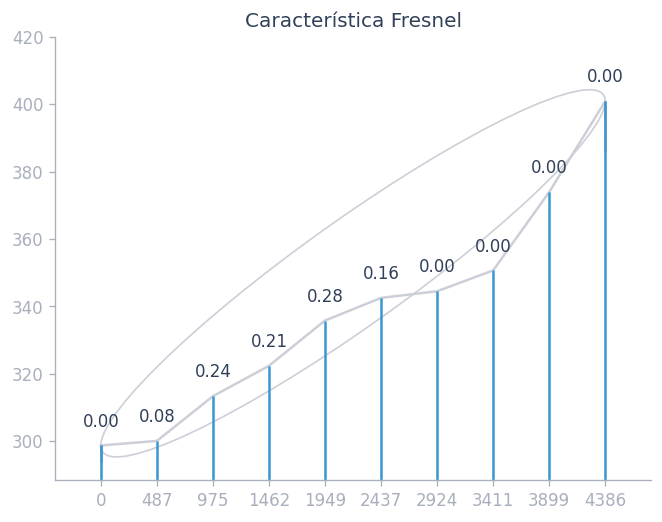

In [9]:
#Característica de Fresnel
#Torres
cplot = plt.figure()
ax = cplot.gca()
plt.xlim(-De*0.09,Dalt*1.09)
ax.plot(distVec,eVec, markersize = 5, color = sClr2_d)#colors[4].hex
fresEllips = Ellipse(xy = (Xc,Yc), fill = False, width = 2*a, height = 2*b, angle = math.degrees(beta), color = sClr2_d)
plt.vlines(torresD,torresMin,torresMax, color = sClr2)
ax.add_patch(fresEllips)
yMins = [hmin - hn*0.05]*n
cpVec = eVec.copy()
cpVec[0] = h1
cpVec[-1] = h2
plt.vlines(distVec,yMins,cpVec, color = mClr)
#Obstrucción de la zona de Fresnel
obVec = ff.fresnelOVec(downP,upP,eVec, yhdiVec)
stp = De/n
lEq2 = lambda xi: m*(xi) + b0*1.08
ystp = np.max(yhdiVec)
for count, i in enumerate(obVec):
    cx = distVec[count]# + stp*0.4
    cy = cpVec[count] + ystp*0.3
    plt.annotate(format(i,'.2f'),(cx,cy), ha='center', color = sClr1, fontsize = 10)

#Modficiando tamaño de eje vertical
plt.ylim(hmin - hn*0.05,ax.get_yticks()[-1])
#Modificación final de gráfico.
plt.xticks(ticks = distVec)
plt.title("Característica Fresnel")
plt.show()

El vector de *n* números posicionando sobre las líneas verticales es la característica de Fresnel deseada. Como parte del análisis de Fresnel se generó el vector de distancias y el vector elevación. Se evalúa la viabilidad de utilizar esas características en la fase de *Selección de Características*.
    
El análisis anterior está comprendido en la función ```fresnelAnalysis(lnkDic, n, fPlot)``` que recibe como parámetros los datos del enlace, la cantidad de puntos a analizar y la indicación de graficar o no el enlace. Esta devuelve los vectores ```(obVec, distVec, eVec)```, que son las nuevas características del conjunto de datos.

## Función fresnelAnalysis

Es posible variar la cantidad de puntos para muestrear la longitud horizontal, siendo 2 el mínimo. La gráfica y las etiquetas desplegadas se ajustarán dependiendo del tamaño de puntos "n". La bandera fPlot indicará si es necesario graficar o no.

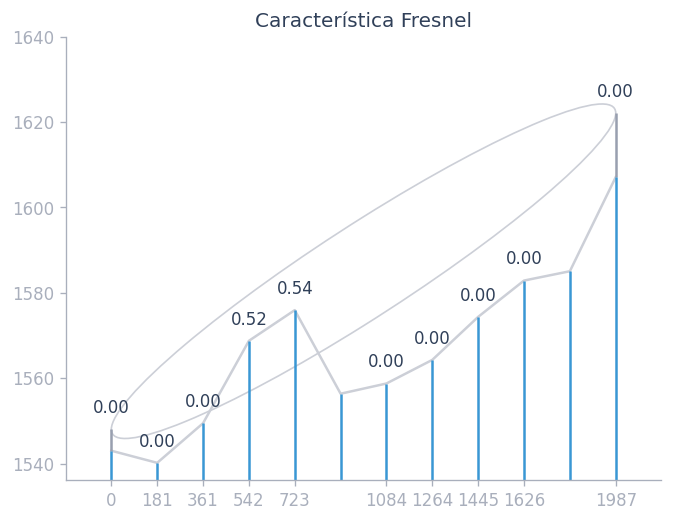

In [9]:
linkData1 = {
    'lat1' :  14.5416,
    'lon1' : -90.7246,
    'h1' : 5,
    'lat2' :  14.5241,
    'lon2' : -90.7283,
    'h2' : 15,
    'freq' : 915000000,
    }
ff1 = ff.fresnelAnalysis(linkData1, n = 12, fPlot = True)

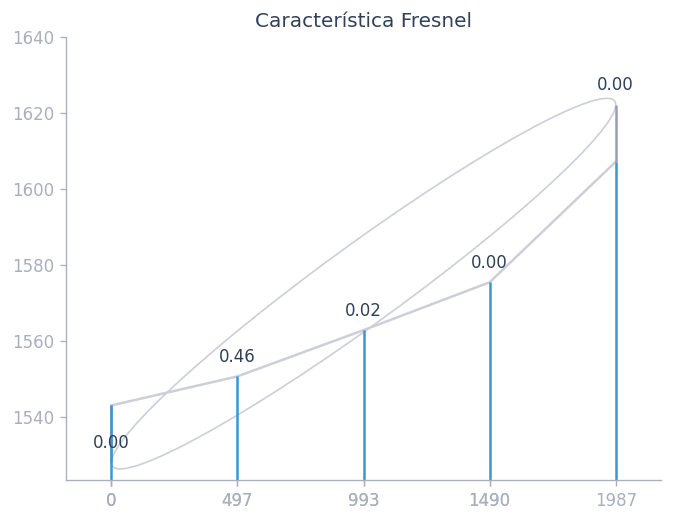

Características generadas


(array([0.  , 0.46, 0.02, 0.  , 0.  ]),
 [0,
  496.7171802070176,
  993.4347557993738,
  1490.152726660947,
  1986.8710926752694],
 [1543.003295898438,
  1550.650024414062,
  1562.81787109375,
  1575.411010742188,
  1607.123779296875])

In [10]:
linkData2 = {
    'lat1' :  14.5416,
    'lon1' : -90.7246,
    'h1' : -15,
    'lat2' :  14.5241,
    'lon2' : -90.7283,
    'h2' : 15,
    'freq' : 915000000,
    }
ff2 = ff.fresnelAnalysis(linkData2, n = 5, fPlot = True)
print("Características generadas")
ff2

## Buscando la simetría

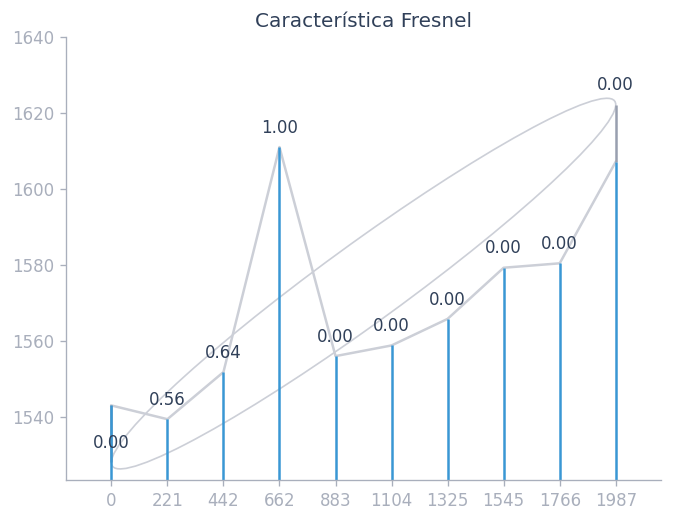

Características generadas


(array([0.  , 0.56, 0.64, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 [0,
  220.71231216572588,
  441.53367432212275,
  662.2461424336842,
  883.067660893043,
  1103.801873045993,
  1324.6235458978401,
  1545.3363264477493,
  1766.1581560425295,
  1986.8710926752694],
 [1543.003295898438,
  1539.384765625,
  1551.78564453125,
  1610.984130859375,
  1555.986328125,
  1558.789916992188,
  1565.783935546875,
  1579.239013671875,
  1580.400756835938,
  1607.123779296875])

In [11]:
linkData3 = {
    'lat1' :  14.5416,
    'lon1' : -90.7246,
    'h1' : -15,
    'lat2' :  14.5241,
    'lon2' : -90.7283,
    'h2' : 15,
    'freq' : 915000000,
    }
ff3 = ff.fresnelAnalysis(linkData3, n = 10, fPlot = True)
print("Características generadas")
ff3

Al invertir el orden de los puntos se obtiene lo siguiente:

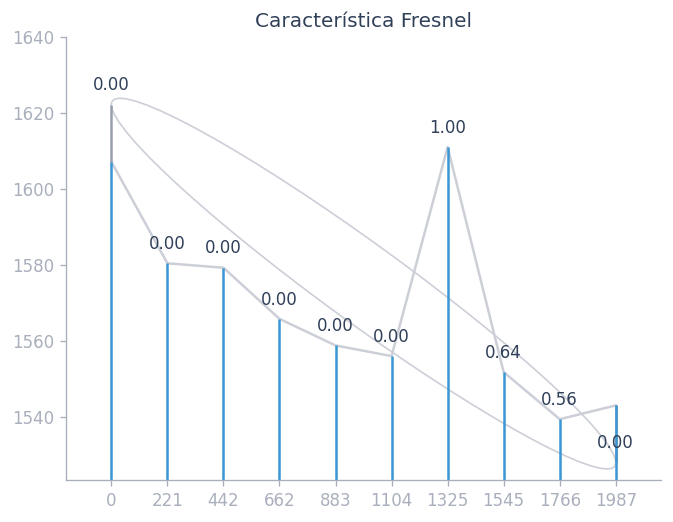

Características generadas


(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.64, 0.56, 0.  ]),
 [0,
  220.7129366370902,
  441.5347668374284,
  662.2475472634964,
  883.0692216067663,
  1103.803435405942,
  1324.6249516081846,
  1545.3374197861258,
  1766.1587805713357,
  1986.8710926752694],
 [1607.123779296875,
  1580.400756835938,
  1579.239013671875,
  1565.783935546875,
  1558.789916992188,
  1555.986328125,
  1610.984130859375,
  1551.78564453125,
  1539.384765625,
  1543.003295898438])

In [12]:
linkData4 = {
    'lat1' : 14.5241,
    'lon1' : -90.7283,
    'h1' : 15,
    'lat2' : 14.5416,
    'lon2' : -90.7246,
    'h2' : -15,
    'freq' : 915000000,
    }
ff4 = ff.fresnelAnalysis(linkData4, n = 10, fPlot = True)
print("Características generadas")
ff4

Para los propósitos de este trabajo es suficiente el nivel de simetría apreciado en las gráficas y en los valores de las características generadas. Esto es la justificación para la estrategia que se utilizó en la generación de la característica de Fresnel, la cual es referida en el trabajo escrito.